In [14]:
# Standard Imports
import numpy as np
import pandas as pd
import tensorflow as tf
print("TF Version:", tf.__version__)
import math
import matplotlib.pyplot as plt

# Fetch competition dataset
!kaggle competitions download -c titanic

TF Version: 1.15.0
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 6.99MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 60.6MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.7MB/s]


# Kaggle Titanic Competition

So the goal is to predict whether, given a set of features of a given passenger aboard the titanic, they would have survived the shipwreck or not.

The training data is comprised of these features for a collection of passengers, and whether they survived or not. Let's take a look at the data.

In [161]:
DATASET = pd.read_csv('train.csv')
TEST_DATASET = pd.read_csv('test.csv')
DATASET.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
DATASET.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [29]:
DATASET.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There's data we can completely discard:
- `PassengerId`, `Name`, and `Ticket` are unique identifiers and don't give us any useful information
- `Cabin` is very sparse, about 7/9ths of entries have no cabin number, so we may as well ignore it

In [100]:
from sklearn.preprocessing import OrdinalEncoder

explore = DATASET.copy()
explore = explore.drop(["PassengerId","Name","Cabin","Ticket"], axis=1)

# Encode Sex into two separate categorical columns
explore["Sex"] = OrdinalEncoder().fit_transform(explore[["Sex"]])

explore.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1.0,22.0,1,0,7.2500,S
1,1,1,0.0,38.0,1,0,71.2833,C
2,1,3,0.0,26.0,0,0,7.9250,S
3,1,1,0.0,35.0,1,0,53.1000,S
4,0,3,1.0,35.0,0,0,8.0500,S


In [101]:
explore.corr().Survived.sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Sex        -0.543351
Name: Survived, dtype: float64

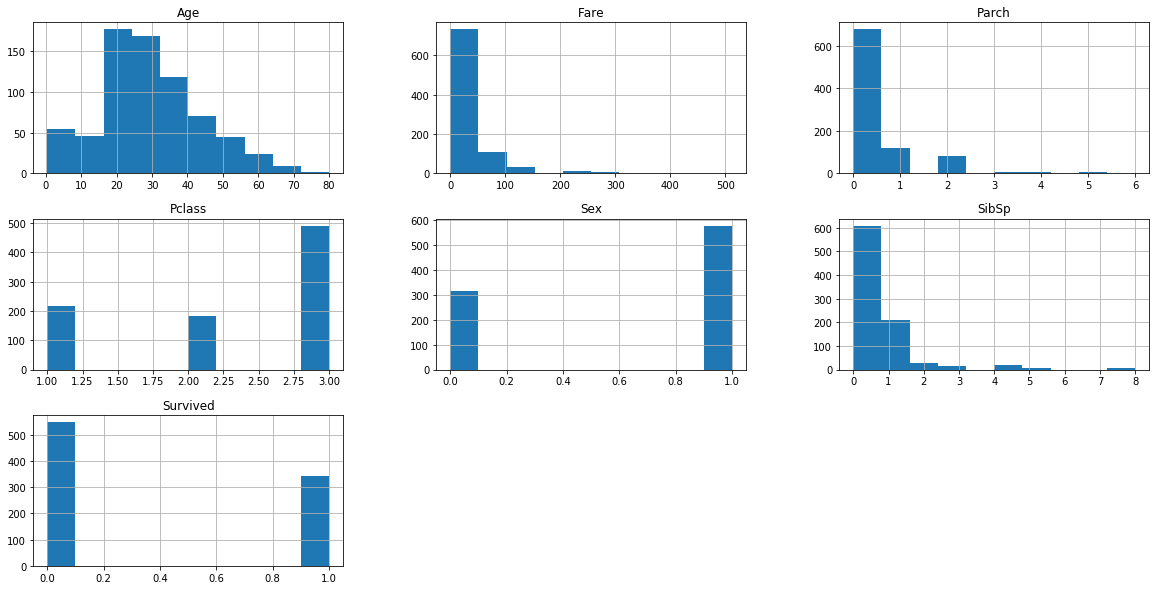

In [102]:
explore.hist(figsize=(20,10))
print()

`Age` is a decent enough contributor, as seen from the matrix and histograms, to need to stratify it. Let's make a good train-test split

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_attribs = ["Age","Fare","Parch","SibSp"]
cat_attribs = ["Sex","Pclass"]

num_pipeline = Pipeline([ 
                         ("imputer", SimpleImputer(strategy="median")),
                         ("std_scaler", StandardScaler()) 
])

pipeline = ColumnTransformer([
                              ("cat", OrdinalEncoder(), cat_attribs),
                              ("num", num_pipeline, num_attribs)
 ])

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

titanic = pipeline.fit_transform(DATASET)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

TRAIN = None
TEST = None

train, test = next(sss.split(titanic, titanic[:,0]))

TRAIN = np.apply_along_axis(lambda i: titanic[i], 0, train)
LABELS = DATASET.Survived.loc[train].values

TEST = np.apply_along_axis(lambda i: titanic[i], 0, test)

Will good old logistic regression do?

In [0]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(
    loss='log',
)

trained_model = model.fit(TRAIN, LABELS)

In [170]:
trained_model.score(TRAIN, LABELS)

0.8019662921348315

Let's establish a good baseline

In [0]:
# Predict Test
titanic_test = pipeline.transform(TEST_DATASET)
predictions = trained_model.predict(titanic_test)

xs = list(range(len(predictions)))

output = pd.DataFrame({ 
    'PassengerId': TEST_DATASET['PassengerId'],
    'Survived': predictions
})

output.to_csv('output.csv', index=False)

In [186]:
# Submit to Kaggle (BE CAREFUL WITH THS!)

!kaggle competitions submit -f output.csv -m "Baseline" titanic

100% 2.77k/2.77k [00:00<00:00, 10.7kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster